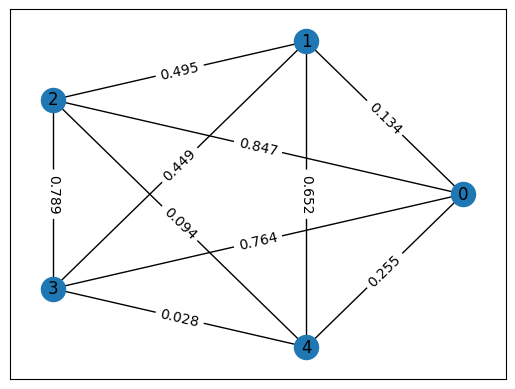

In [13]:
import networkx
import random
import scipy

def generate_graph(n, seed=1):
    graph = networkx.Graph()
    edge_list = []
    for n1 in range(n):
        for n2 in range(n1+1,n):
            edge_list.append((n1,n2))
    
    graph.add_edges_from(edge_list)
    random.seed(seed)
    weights = [random.random() for i in range(len(edge_list))]

    for index, edge in enumerate(graph.edges()):
        graph.get_edge_data(*edge)['weight'] = weights[index]

    return graph, weights

no_vertices = 5
graph = generate_graph(no_vertices)[0]
pos=networkx.circular_layout(graph)
networkx.draw_networkx(graph, pos)
labels = networkx.get_edge_attributes(graph,'weight')
for edge in labels:
    labels[edge] = round(labels[edge], 3)
tmp = networkx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)


In [14]:
from src_code import build_operators

hamiltonian = build_operators.cut_hamiltonian(graph=graph)
gradient_ops_dict = build_operators.build_all_mixers(graph=graph)
pauli_ops_dict = build_operators.build_all_paulis(no_vertices)

In [15]:
from src_code import useful_methods

max_cut_solution = useful_methods.find_optimal_cut(graph)
max_cut_value = max_cut_solution[1]
max_ham_eigenvalue = max_cut_solution[2]
ham_offset = max_cut_value - max_ham_eigenvalue

hamiltonian = build_operators.cut_hamiltonian(graph)
mix_hamiltonian = build_operators.mix_hamiltonian(graph)
det_ham = scipy.linalg.norm(hamiltonian.toarray(),2)
det_mix = scipy.linalg.norm(mix_hamiltonian.toarray(),2)

beta = 0
delta_t = 0.1
ham_approx_ratios = []
cut_approx_ratios = []

max_layers = 100
layer = 0

curr_dens_mat = build_operators.initial_density_matrix(no_vertices)

In [16]:
def build_layer(curr_dens_mat,beta, delta_t):
    """ one layer 
    """
    cut_unit = build_operators.cut_unitary(graph,delta_t,pauli_ops_dict)
    curr_dens_mat = (cut_unit * curr_dens_mat) * (cut_unit.transpose().conj())

    mix_unit = build_operators.mixer_unitary('standard_x', beta * delta_t, pauli_ops_dict, no_vertices)
    curr_dens_mat = (mix_unit * curr_dens_mat) * (mix_unit.transpose().conj())

    return curr_dens_mat

In [17]:
def update_time(curr_dens_mat):

    A = 1j*(mix_hamiltonian*hamiltonian - hamiltonian * mix_hamiltonian) * curr_dens_mat
    expectation = A.trace().real
    #Hdp = mix_hamiltonian * hamiltonian - hamiltonian * mix_hamiltonian
    #Hpdp = ((hamiltonian * Hdp - Hdp * hamiltonian) * curr_dens_mat).trace().real
    #Hddp = ((mix_hamiltonian * Hdp - Hdp * hamiltonian) * curr_dens_mat).trace().real

    delta_t = abs(expectation) / (2*(2* det_ham * det_mix + abs(expectation)) * (det_ham + det_mix * beta))

    #delta_t = abs(expectation) / (Hddp + Hddp * beta)

    print(delta_t, end=' ')
    return delta_t 

In [18]:
while layer < max_layers:
    layer += 1
    curr_dens_mat = build_layer(curr_dens_mat, beta, delta_t)
    if beta == 0:
        beta = 3
    delta_t = update_time(curr_dens_mat)

    hamiltonian_expectation = (hamiltonian * curr_dens_mat).trace().real
    ham_approx_ratio = hamiltonian_expectation / max_ham_eigenvalue
    cut_approx_ratio = (hamiltonian_expectation + max_cut_value - max_ham_eigenvalue) / max_cut_value

    print("layer", layer, ": ", cut_approx_ratio,sep='')

0.0007207977223839499 layer1: 0.6509321521861706
0.0007255075054479026 layer2: 0.6512936799221738
0.0007301837360972178 layer3: 0.6516599908513921
0.0007348245927452704 layer4: 0.6520310822175175
0.0007394282383436227 layer5: 0.6524069486952082
0.0007439928216293051 layer6: 0.6527875823297118
0.0007485164784259734 layer7: 0.6531729724782434
0.0007529973329983299 layer8: 0.6535631057532862
0.0007574334994590577 layer9: 0.6539579659679927
0.0007618230832273599 layer10: 0.654357534083855
0.0007661641825380208 layer11: 0.6547617881608233
0.0007704548899997765 layer12: 0.6551707033100473
0.0007746932942015788 layer13: 0.6555842516494123
0.0007788774813651967 layer14: 0.6560024022620478
0.0007830055370424266 layer15: 0.6564251211579801
0.0007870755478549998 layer16: 0.6568523712390972
0.0007910856032751218 layer17: 0.6572841122675958
0.0007950337974444061 layer18: 0.6577203008380739
0.0007989182310287885 layer19: 0.6581608903534291
0.000802737013106855 layer20: 0.6586058310047165
0.000806488